### PLACE ALL IMPORTS HERE (easier to keep track of)

In [198]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

In [199]:
source_dir = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\book-nlp-master\\book-nlp-master\\data\\originalTexts"
bookfile = open(source_dir + '\\full_hp.txt', 'r')
book = bookfile.read()
bookDict = defaultdict(float)
for word in book.split():
    bookDict[word] += 1
counter = Counter(bookDict)
top_n = counter.most_common(200)
print top_n
print

[('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so', 2241.0), ('this', 2197.0)

#### Paste in direct path to the JSON file (because the relative paths aren't working)

In [200]:
wk_dir = os.path.dirname(os.path.realpath('__file__'))

#json_filename = os.path.join(wk_dir, "..", "booknlp_output\\potter.all.book.txt")
json_filename = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\char-net\\booknlp_output\\book.id.book";

with open(json_filename) as json_file:
	char_json = json.load(json_file)
print "successfully loaded json"

successfully loaded json


#### Load stopwords list, combine it with NLTK's English stopwords list (add words to list as needed)

In [201]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(stemmer.stem(token))
    return filtered_tokens

In [202]:
stopwords = nltk.corpus.stopwords.words('english')
curDir = os.path.dirname(os.path.realpath('__file__'))
stop = os.path.join(curDir,'stopwords')     
stopfile = open(stop, 'r')
stop = stopfile.read()
for word in stop.split():
    stopwords.extend(tokenize_and_stem(word))
# take this out if necessary? just seeing if throwing out the top words improves results
for word in top_n:
    stopwords.extend(tokenize_and_stem(word[0].decode("utf8").lower()))   
print stopwords
stopwords = set(stopwords)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

#### Create character feature vectors

##### Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

In [203]:
# dictionary of lists of character attributes, indexed by name (i.e. character's "bag of words")
characters = {}
character_namelists = {}
total_features = defaultdict(float)

for character in char_json["characters"]:
    # TODO: throw out characters that are mentioned less than n times (play with this threshold?)
    if character["NNPcount"] > 30:
        #changed this to be the full list of names rather than the first one
        namelist = [character["names"][i]['n'] for i in range(len(character["names"]))]
        char_name = character["names"][0]['n']
        #store character's full list of names for later use
        character_namelists[char_name] = namelist
        
        #create feature vector for that character
        characters[char_name] = []
        for word_dict in character["patient"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_PATIENT")
                total_features[curWord[0] + "_PATIENT"] += 1
        for word_dict in character["agent"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_AGENT")
                total_features[curWord[0] + "_AGENT"] += 1
        for word_dict in character["mod"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_MOD")
                total_features[curWord[0] + "_MOD"] += 1
                
        #TODO: add dialogue features?
        for word_dict in character['speaking']:
            curPhrase = word_dict['w']
            spoken_words = tokenize_and_stem(curPhrase)
            for word in spoken_words:
                if word not in stopwords:
                    characters[char_name].append(word + "_SAY")
                    total_features[word + "_SAY"] += 1
                
        # are things characters possess indicative of their character? Often not, so maybe exclude
        for word_dict in character["poss"]:
            curWord = tokenize_and_stem(word_dict['w'])
            if len(curWord) > 0 and curWord[0].lower() not in stopwords:
                characters[char_name].append(curWord[0] + "_POSS")
                total_features[curWord[0] + "_POSS"] += 1

texts = [None for i in range(len(characters))]
names = defaultdict(float)
i = 0
for key, value in characters.iteritems():
	print str(key) + ": " + str(value)
	texts[i] = value
	names[key] = i
	i += 1
	print
print len(characters)

Madam Rosmerta: [u'forc_PATIENT', u'gasp_PATIENT', u'breath_PATIENT', u'stare_AGENT', u'fill_AGENT', u'eject_wizard_AGENT', u'totter_AGENT', u'send_bottl_AGENT', u'have_oth_AGENT', u'tip_you_AGENT', u'help__AGENT', u'admit_AGENT', u'let_sigh_AGENT', u'abl_MOD', u'stay_SAY', u'black_SAY', u'area_SAY', u'minist_SAY', u'dementor_SAY', u'search_SAY', u'whole_SAY', u'villag_SAY', u'twjce_SAY', u'worst_SAY', u'wors_SAY', u'murder_SAY', u'poor_SAY', u'mean_SAY', u'natur_SAY', u'black_SAY', u'leagu_SAY', u'doe_SAY', u'work_SAY', u'black_SAY', u'potter_SAY', u'secret-keep_SAY', u'suspect_SAY', u'black_SAY', u'black_SAY', u'betray_SAY', u'manag_SAY', u'disappear_SAY', u'ministri_SAY', u'magic_SAY', u'caught_SAY', u'next_SAY', u'day_SAY', u'pettigrew_SAY', u'fat_SAY', u'boy_SAY', u'alway_SAY', u'tag_SAY', u'hogwart_SAY', u'black_SAY', u'taken_SAY', u'twenti_SAY', u'member_SAY', u'magic_SAY', u'law_SAY', u'enforc_SAY', u'squad_SAY', u'pettigrew_SAY', u'receiv_SAY', u'order_SAY', u'merlin_SAY', u'c

In [204]:
counter = Counter(total_features)
top_n = counter.most_common(50)
print top_n
print

[(u'oh_SAY', 396.0), (u'yes_SAY', 358.0), (u'stare_AGENT', 333.0), (u'yeah_SAY', 308.0), (u'potter_SAY', 296.0), (u'good_SAY', 268.0), (u'shoulder_POSS', 266.0), (u'tell__AGENT', 257.0), (u'stood_AGENT', 255.0), (u'walk_AGENT', 253.0), (u'sat_AGENT', 249.0), (u'whi_SAY', 248.0), (u'robe_POSS', 245.0), (u'hair_POSS', 219.0), (u'mean_SAY', 218.0), (u'thing_SAY', 211.0), (u'ear_POSS', 210.0), (u'mind_POSS', 205.0), (u'cours_SAY', 205.0), (u'doe_SAY', 196.0), (u'move_AGENT', 193.0), (u'need_SAY', 192.0), (u'ad_AGENT', 192.0), (u'year_SAY', 179.0), (u'magic_SAY', 171.0), (u'offic_POSS', 169.0), (u'sure_MOD', 169.0), (u'glanc_AGENT', 169.0), (u'dark_SAY', 164.0), (u'start_AGENT', 164.0), (u'stand_AGENT', 164.0), (u'heart_POSS', 163.0), (u'watch_PATIENT', 163.0), (u'yeh_SAY', 156.0), (u'ask__AGENT', 155.0), (u'sit_AGENT', 155.0), (u'sure_SAY', 153.0), (u'happen_SAY', 153.0), (u'hurri_AGENT', 148.0), (u'bit_SAY', 148.0), (u'mother_POSS', 147.0), (u'pocket_POSS', 145.0), (u'stop_AGENT', 144.0),

## Do LDA Topic Modeling Using Character Features

In [205]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 8

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce good results.

In [206]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [207]:
print(lda.show_topics())

[u'0.004*sir_SAY + 0.004*potter_SAY + 0.003*dobbi_SAY + 0.003*stare_AGENT + 0.002*diari_POSS + 0.002*hair_POSS + 0.002*offic_POSS + 0.002*boy_SAY + 0.002*yes_SAY + 0.002*tell__AGENT', u'0.005*master_SAY + 0.004*kreacher_SAY + 0.003*arthur_SAY + 0.003*growl_PATIENT + 0.003*yes_SAY + 0.003*growl_AGENT + 0.002*leav_PATIENT + 0.002*dear_SAY + 0.002*husband_POSS + 0.002*son_POSS', u'0.006*oh_SAY + 0.005*cage_POSS + 0.005*yes_SAY + 0.004*bag_POSS + 0.003*scream_AGENT + 0.002*shoulder_POSS + 0.002*walk_AGENT + 0.002*thing_SAY + 0.002*happen_SAY + 0.002*read_SAY', u'0.006*potter_SAY + 0.005*offic_POSS + 0.003*dark_SAY + 0.003*lord_SAY + 0.003*desk_POSS + 0.003*yes_SAY + 0.003*death_SAY + 0.002*robe_POSS + 0.002*whi_SAY + 0.002*year_SAY', u'0.006*yes_SAY + 0.004*smile_AGENT + 0.004*offic_POSS + 0.003*magic_SAY + 0.003*lord_SAY + 0.002*cours_SAY + 0.002*desk_POSS + 0.002*oh_SAY + 0.002*good_SAY + 0.002*sure_SAY', u'0.007*oh_SAY + 0.004*yeah_SAY + 0.004*good_SAY + 0.004*stare_AGENT + 0.003*yeh_SA

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
sir_SAY potter_SAY dobbi_SAY stare_AGENT diari_POSS hair_POSS offic_POSS boy_SAY yes_SAY tell__AGENT smile_AGENT need_SAY roar_PATIENT mother_POSS kill_SAY magic_SAY school_SAY ministri_SAY escap_AGENT book_POSS gone_AGENT hogwart_SAY thing_SAY sirius_SAY help_PATIENT squeak_PATIENT call_AGENT ear_POSS stay_AGENT stop_AGENT 


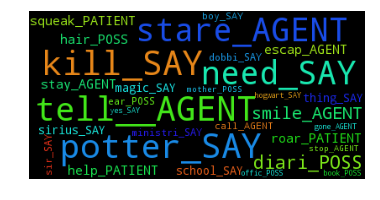

Topic  1
master_SAY kreacher_SAY arthur_SAY growl_PATIENT yes_SAY growl_AGENT leav_PATIENT dear_SAY husband_POSS son_POSS oh_SAY boy_SAY glass_POSS father_SAY snap_AGENT year_SAY good_SAY start_AGENT scream_AGENT regulus_SAY montagu_SAY tale_POSS sob_AGENT flask_POSS cloak_POSS thing_SAY potter_SAY day_SAY return_AGENT quaffl_SAY 


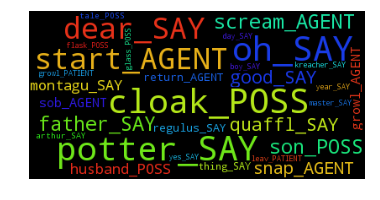

Topic  2
oh_SAY cage_POSS yes_SAY bag_POSS scream_AGENT shoulder_POSS walk_AGENT thing_SAY happen_SAY read_SAY need_SAY robe_POSS pleas_SAY seat_POSS doe_SAY gone_AGENT watch_PATIENT good_SAY began_AGENT return_AGENT join_PATIENT parent_POSS lip_POSS grandmoth_POSS sat_AGENT hair_POSS whi_SAY gasp_PATIENT cours_SAY pull_PATIENT 


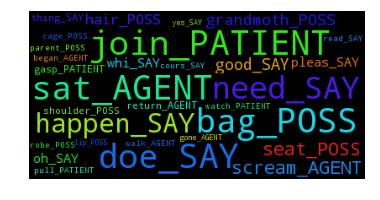

Topic  3
potter_SAY offic_POSS dark_SAY lord_SAY desk_POSS yes_SAY death_SAY robe_POSS whi_SAY year_SAY memori_POSS dementor_SAY severus_SAY oh_SAY draco_SAY smile_AGENT move_AGENT eater_SAY stood_AGENT cloak_POSS need_SAY give_SAY hair_POSS walk_AGENT work_SAY thing_SAY ad_AGENT lip_POSS potion_SAY tell__AGENT 


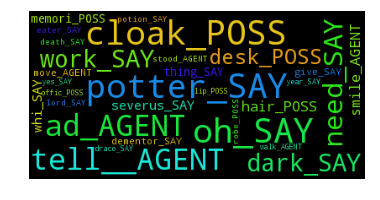

Topic  4
yes_SAY smile_AGENT offic_POSS magic_SAY lord_SAY cours_SAY desk_POSS oh_SAY good_SAY sure_SAY stood_AGENT armi_POSS need_SAY continu_AGENT year_SAY hogwart_SAY school_SAY wizard_SAY ministri_SAY tonight_SAY die_AGENT tell__AGENT find_SAY tell_i_AGENT son_POSS return_SAY champion_SAY shall_SAY mean_SAY give_SAY 


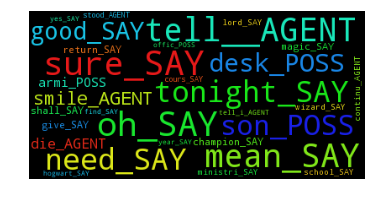

Topic  5
oh_SAY yeah_SAY good_SAY stare_AGENT yeh_SAY whi_SAY tell__AGENT mean_SAY yes_SAY ad_AGENT bit_SAY doe_SAY ter_SAY sit_AGENT cours_SAY hair_POSS thing_SAY sat_AGENT shoulder_POSS magic_SAY stood_AGENT stand_AGENT offic_POSS hollow_POSS potter_SAY ask__AGENT better_SAY sure_SAY robe_POSS talk_SAY 


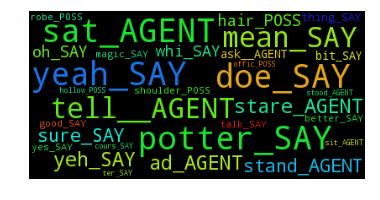

Topic  6
wife_POSS daughter_POSS tell_i_AGENT room_POSS rope_POSS cackl_AGENT cackl_PATIENT son_POSS feed_PATIENT babi_MOD ferret_AGENT resum_AGENT appeal_POSS yard_POSS tell_w_AGENT produc_AGENT goblet_POSS kill_PATIENT save_PATIENT say_what_AGENT see_basilisk_AGENT let_slip_AGENT side_POSS seat_POSS stood_AGENT dodg_PATIENT threaten_PATIENT natur_SAY bit_SAY won_PATIENT 


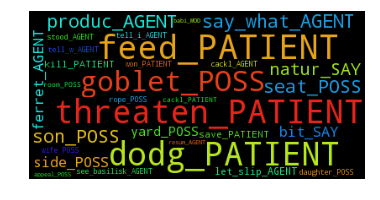

Topic  7
yeah_SAY stare_AGENT mind_POSS shoulder_POSS heart_POSS sure_MOD ear_POSS walk_AGENT stood_AGENT robe_POSS sat_AGENT potter_SAY scar_POSS feel_AGENT tell__AGENT realiz_AGENT glanc_AGENT yes_SAY whi_SAY oh_SAY good_SAY stomach_POSS found_AGENT move_AGENT wonder_AGENT mean_SAY father_POSS ask__AGENT watch_PATIENT hair_POSS 


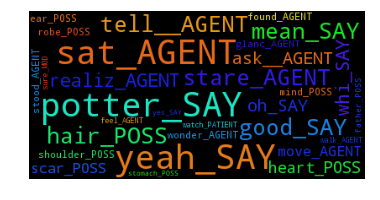

In [208]:
from wordcloud import WordCloud

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for i in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()


#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [209]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

121
0 Madam Rosmerta topic distribution: 
[(3, 0.98905007331320827)]
1 Fang topic distribution: 
[(4, 0.52581328154890528), (5, 0.46827623293581694)]
2 Hogsmeade topic distribution: 
[(0, 0.01042429204345292), (1, 0.010431880342544242), (2, 0.010420651411796839), (3, 0.92703184249471804), (4, 0.010420235353548562), (5, 0.0104319522202663), (6, 0.01041667088608308), (7, 0.010422475247590005)]
3 Lupin topic distribution: 
[(3, 0.99690439572829104)]
4 Dudley topic distribution: 
[(7, 0.99838411560389995)]
5 Cho topic distribution: 
[(3, 0.37702243124629192), (7, 0.61918604402763855)]
6 Madam Hooch topic distribution: 
[(1, 0.99047745528273512)]
7 Lavender Brown topic distribution: 
[(5, 0.98248519824213132)]
8 Bertha Jorkins topic distribution: 
[(7, 0.98692578621412008)]
9 Fred topic distribution: 
[(3, 0.14930798136632017), (5, 0.32151317453782252), (7, 0.52862232186452651)]
10 Marietta topic distribution: 
[(4, 0.9869241573087395)]
11 Rufus Scrimgeour topic distribution: 
[(4, 0.979632

#### Bar plot visualization of above character topic probabilities

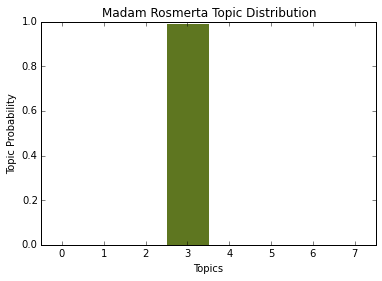

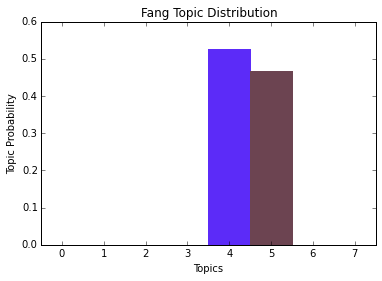

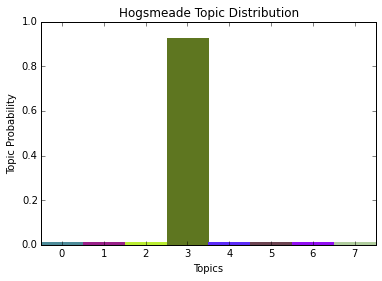

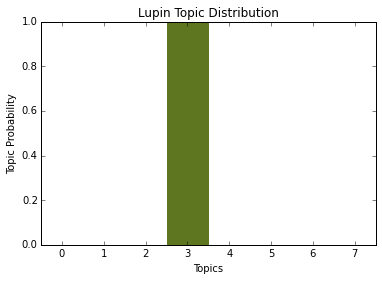

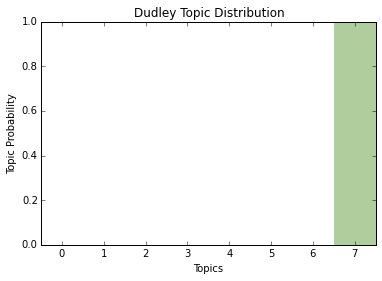

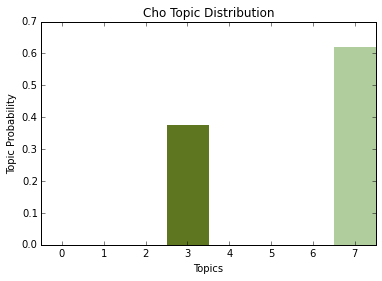

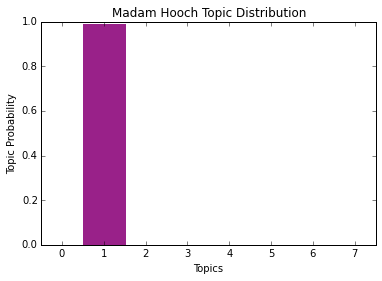

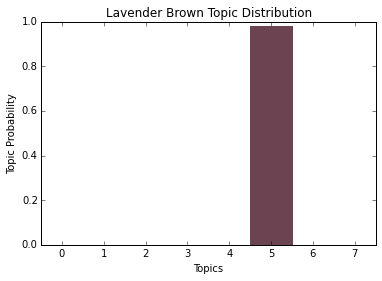

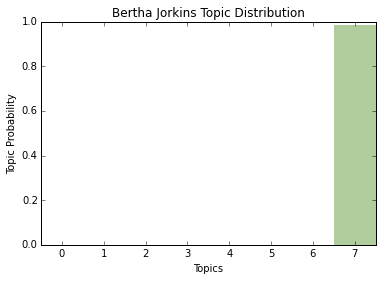

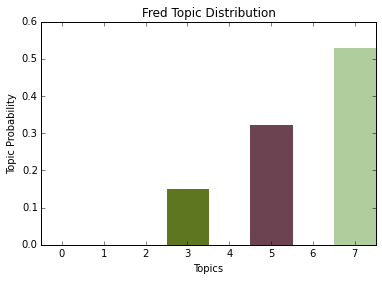

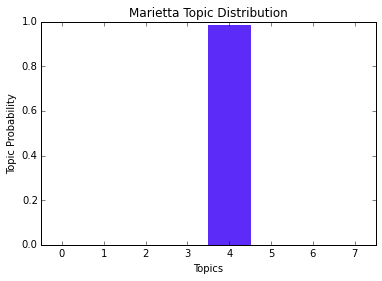

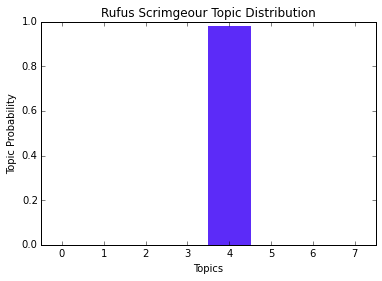

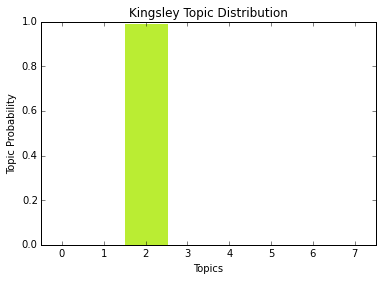

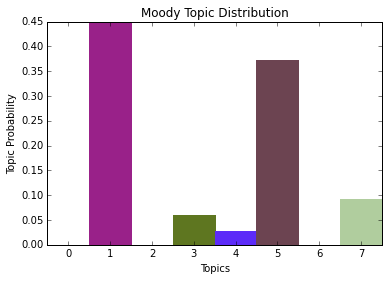

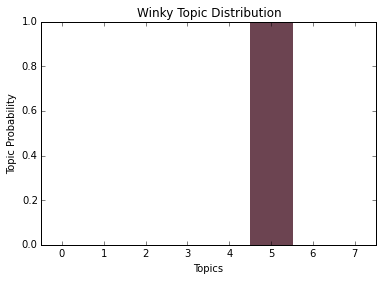

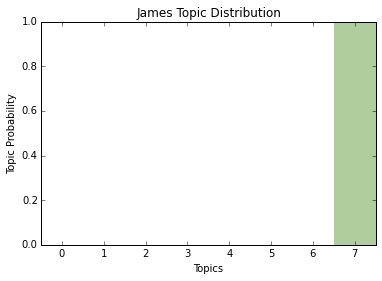

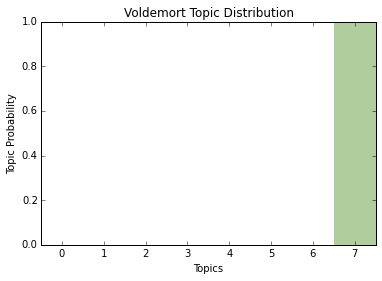

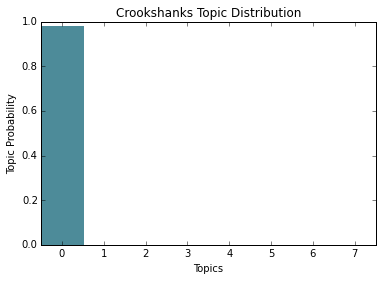

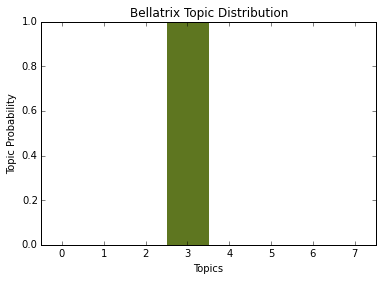

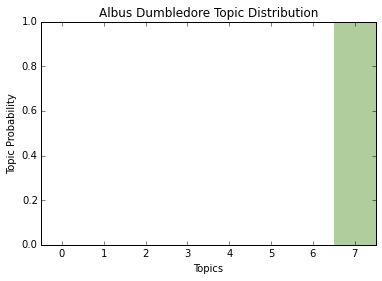

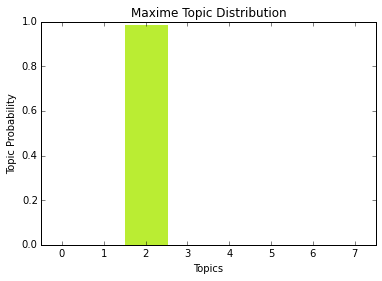

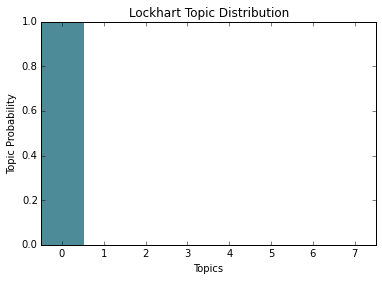

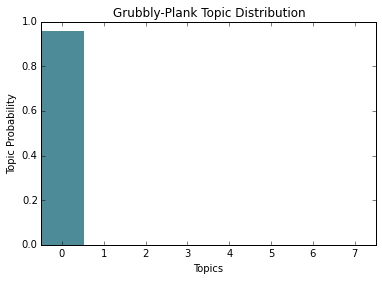

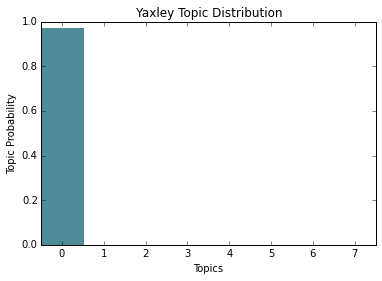

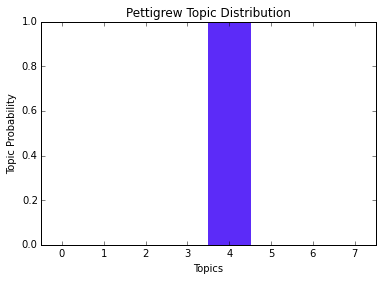

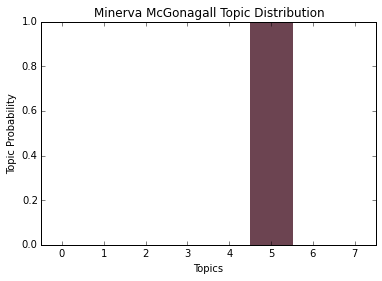

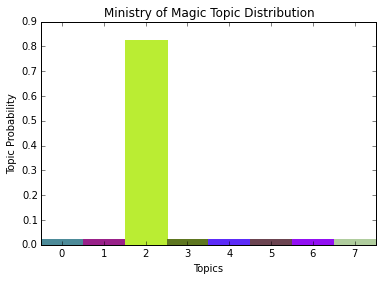

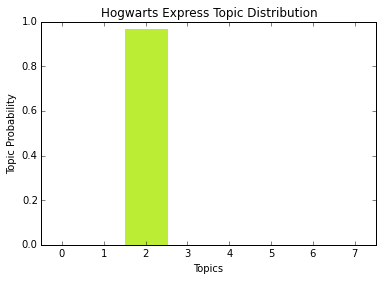

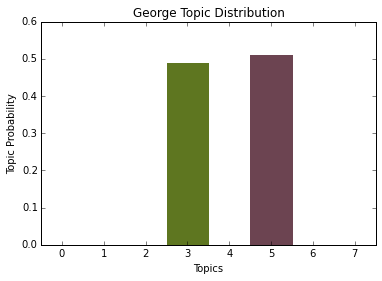

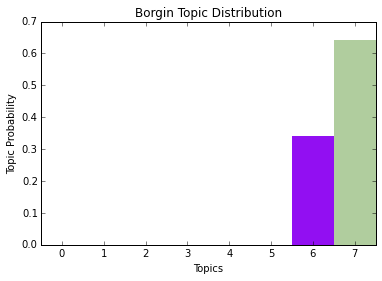

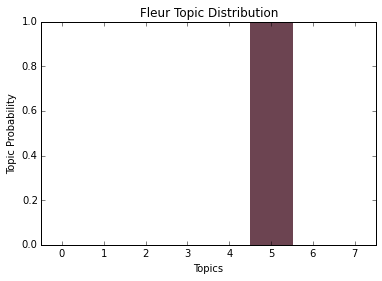

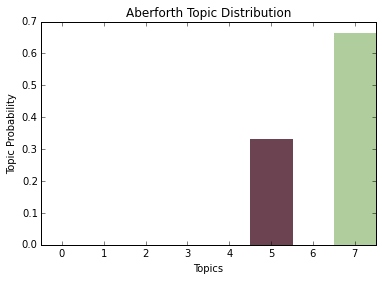

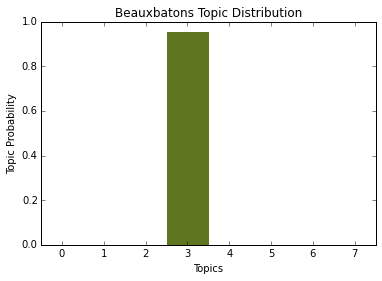

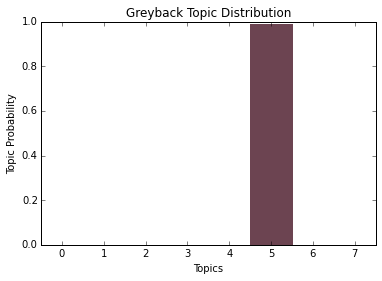

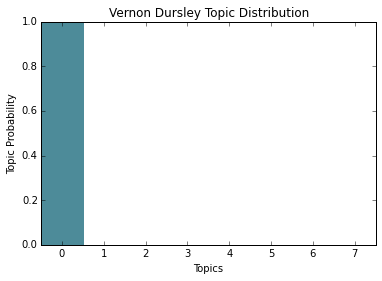

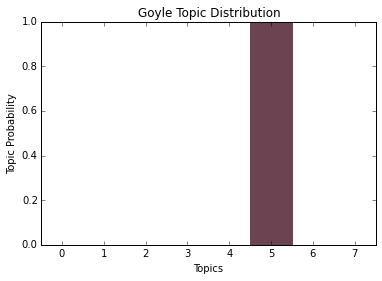

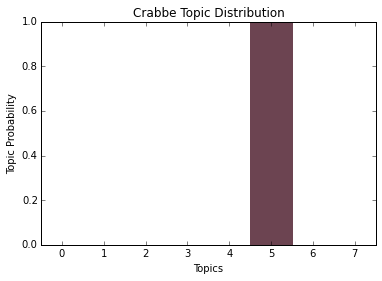

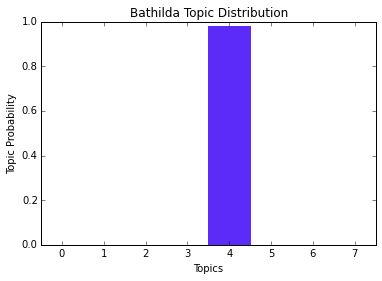

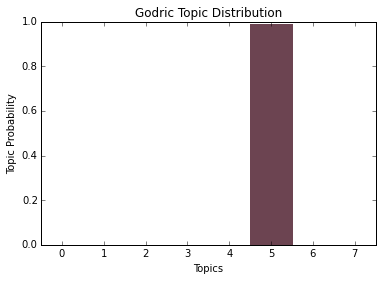

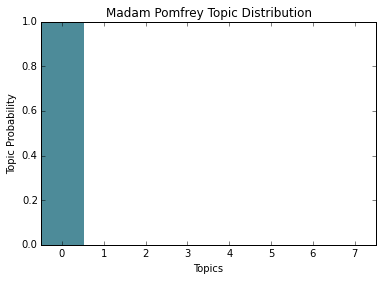

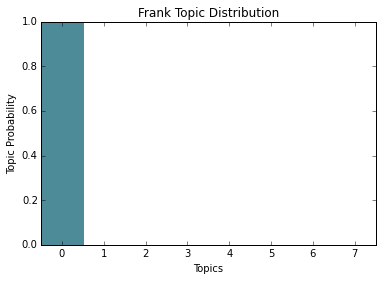

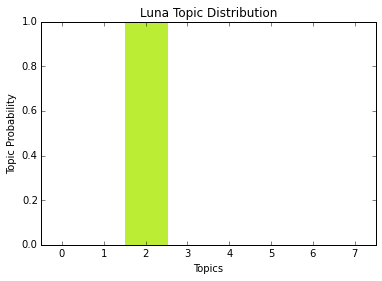

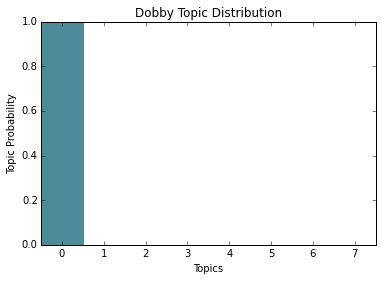

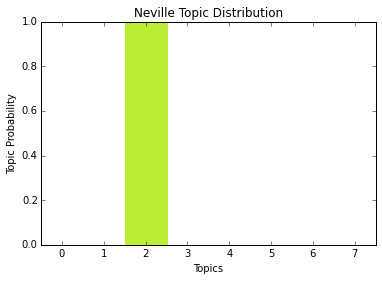

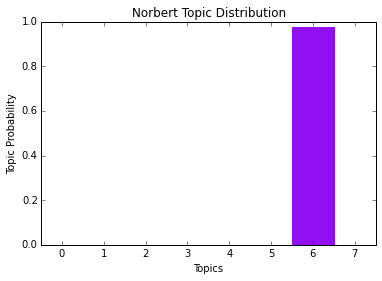

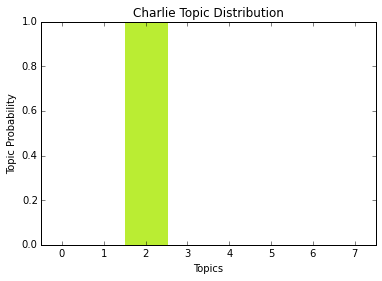

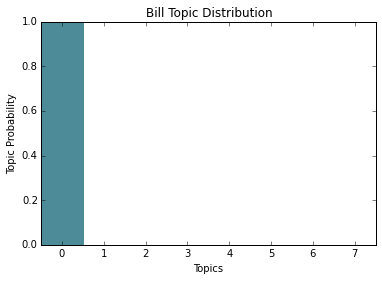

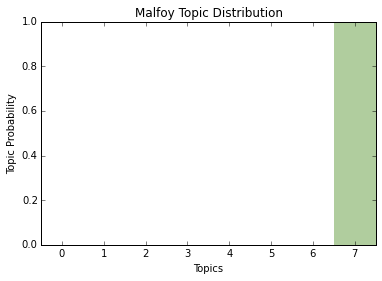

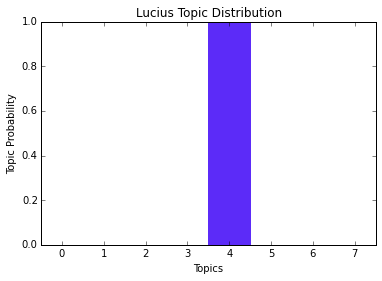

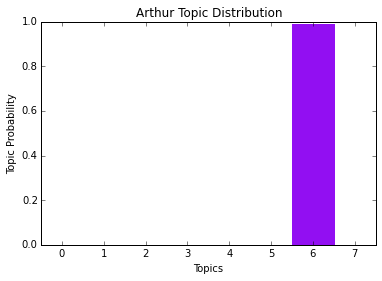

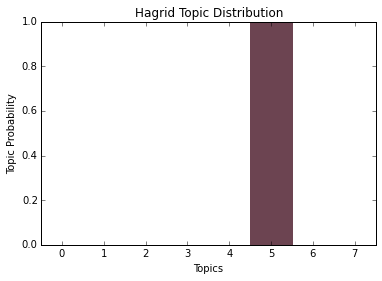

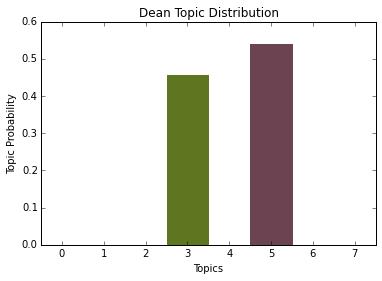

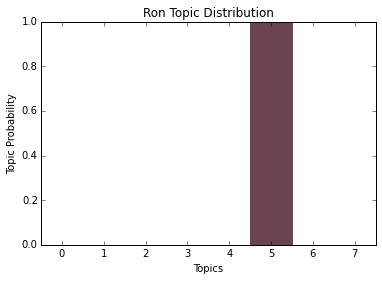

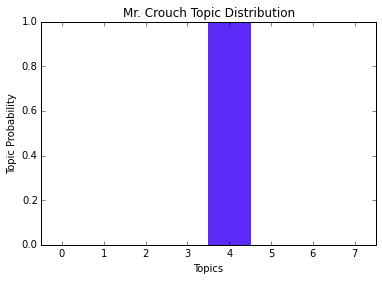

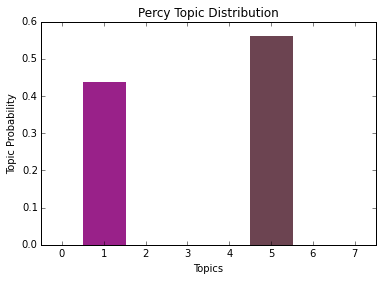

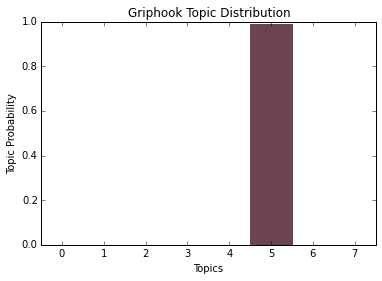

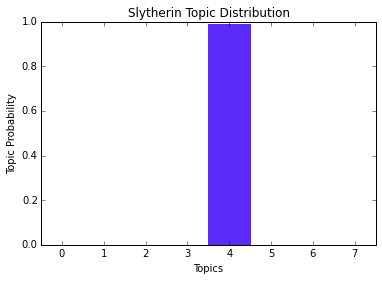

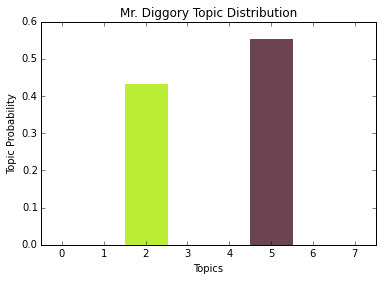

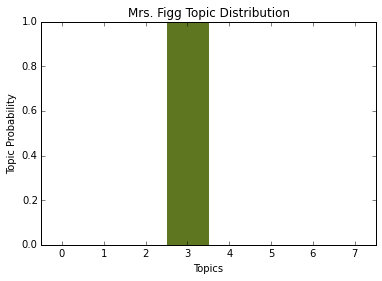

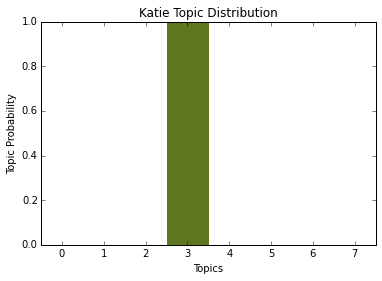

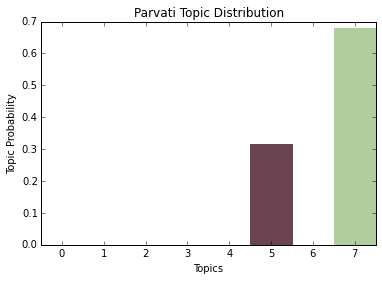

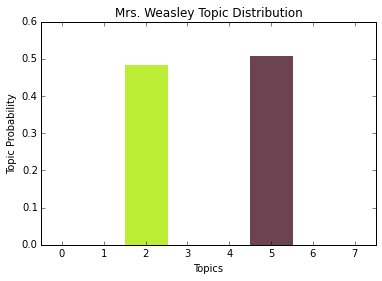

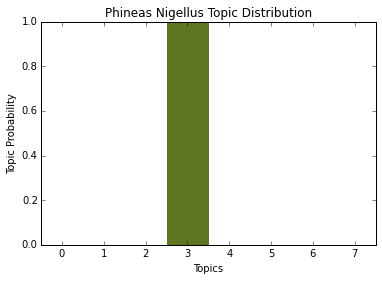

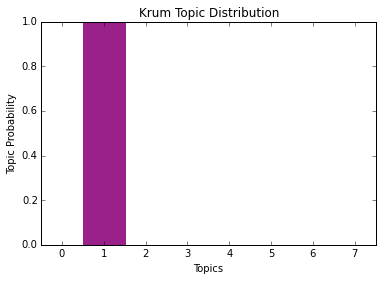

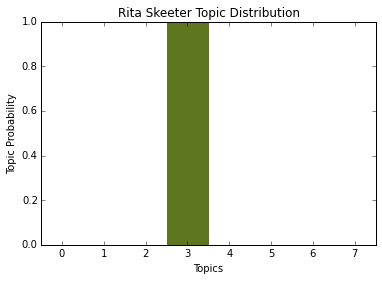

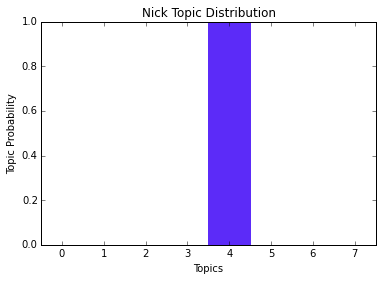

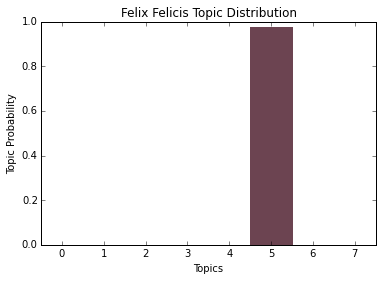

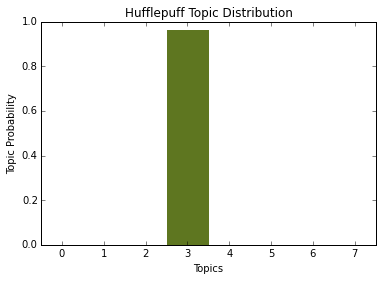

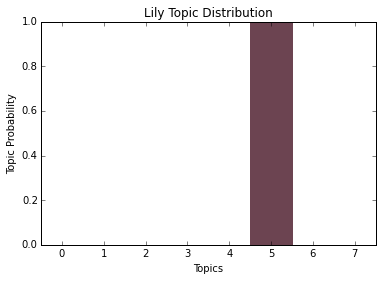

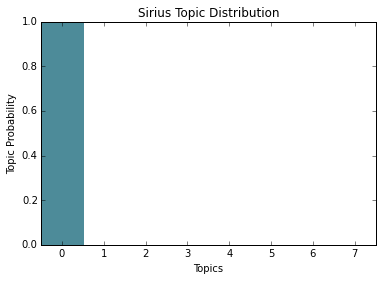

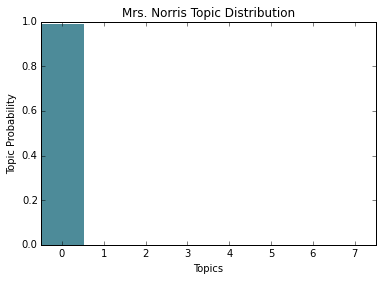

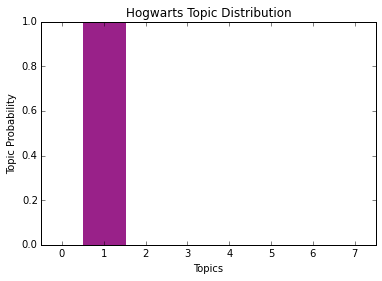

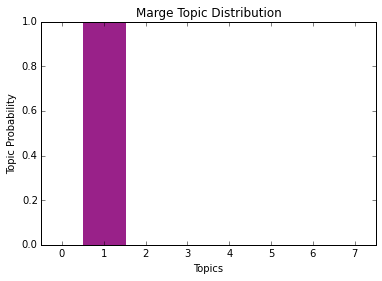

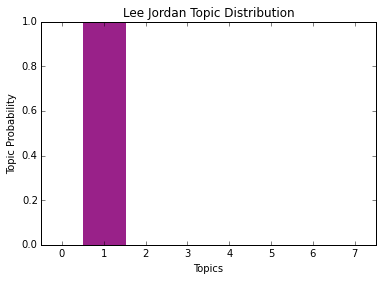

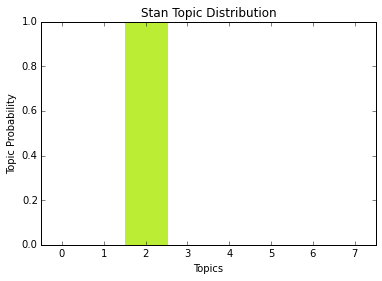

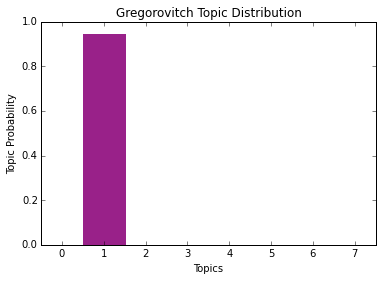

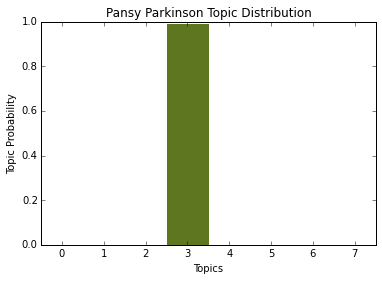

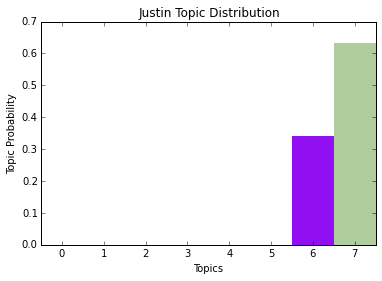

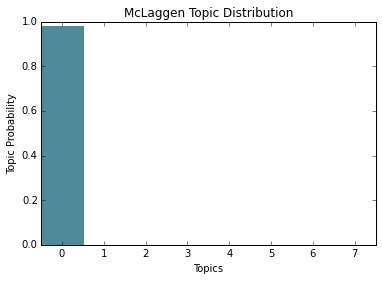

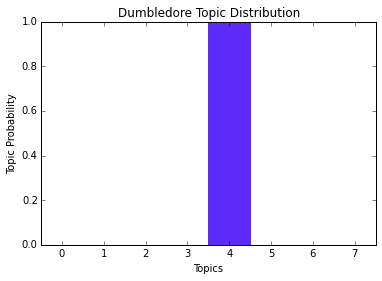

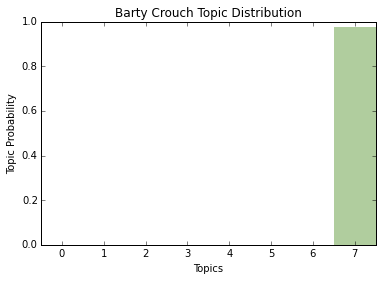

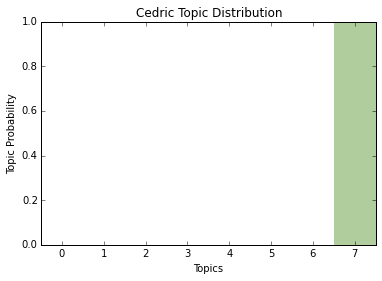

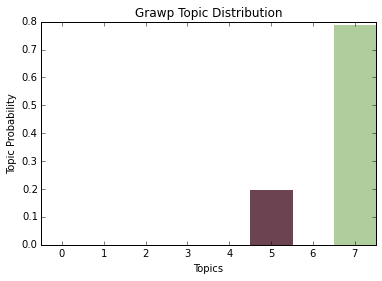

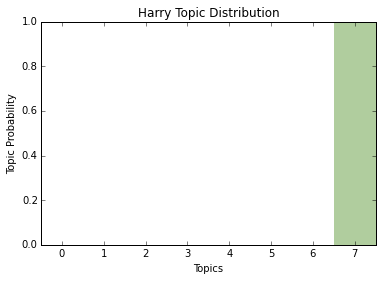

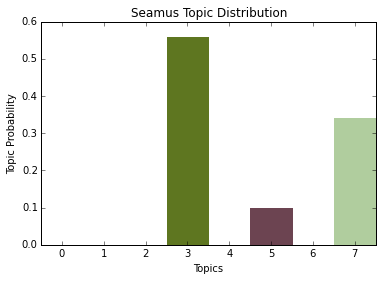

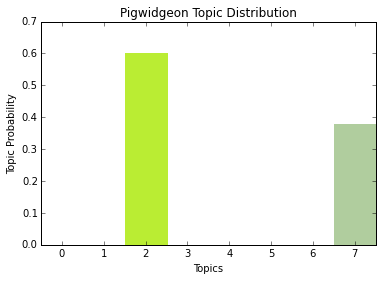

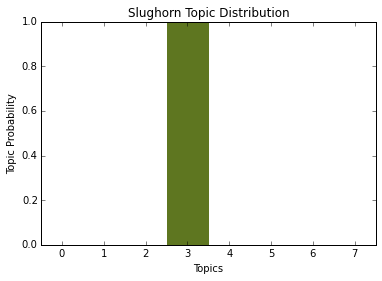

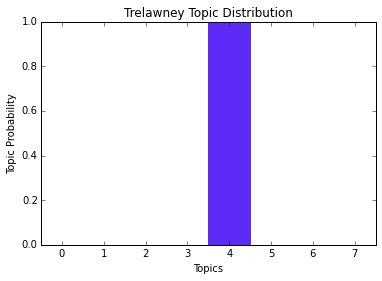

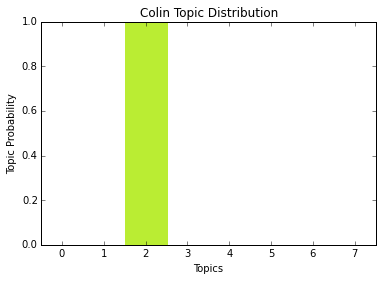

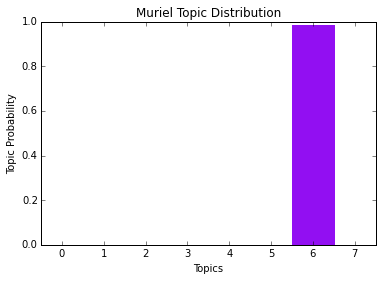

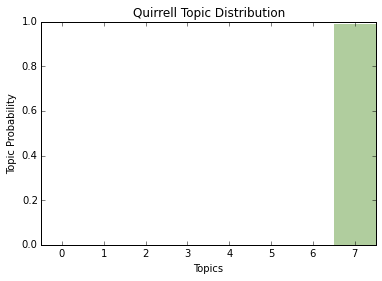

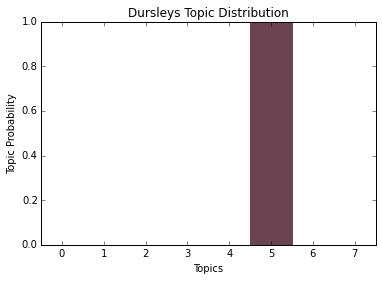

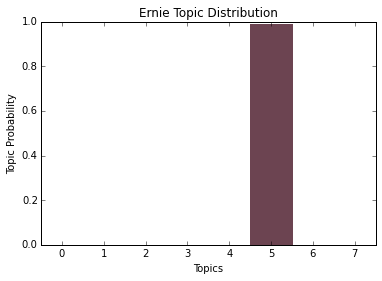

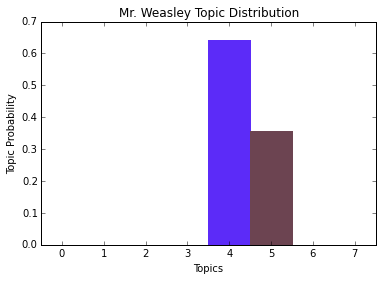

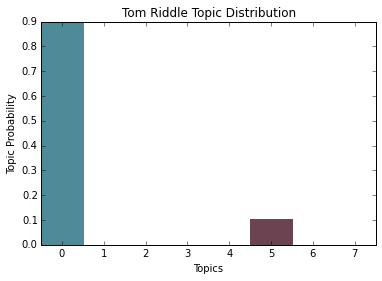

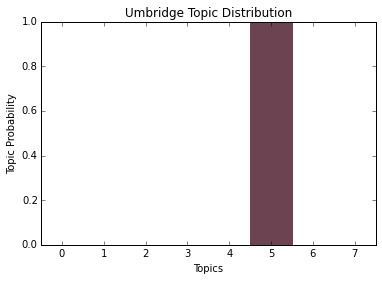

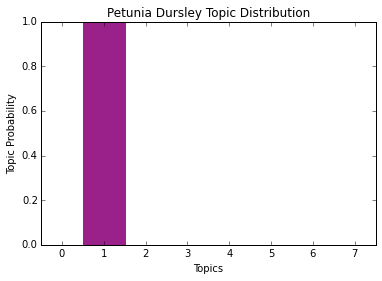

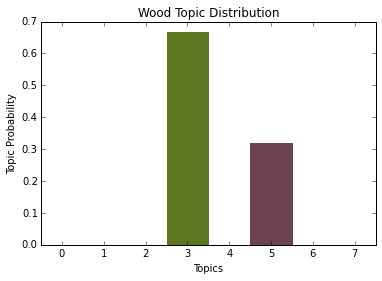

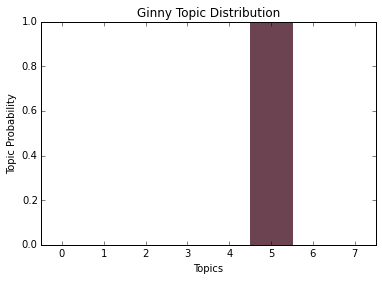

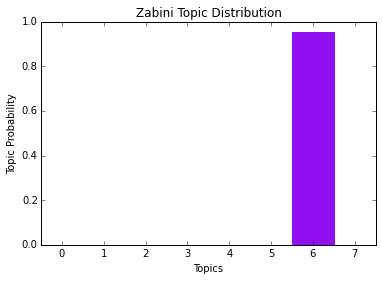

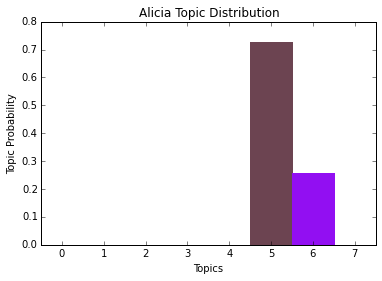

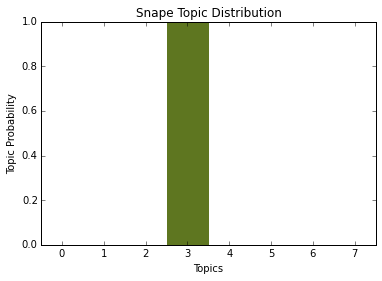

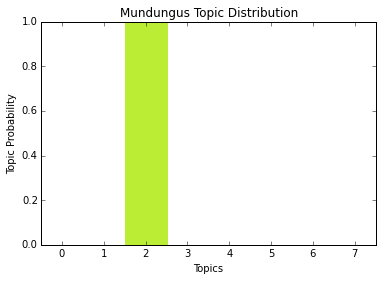

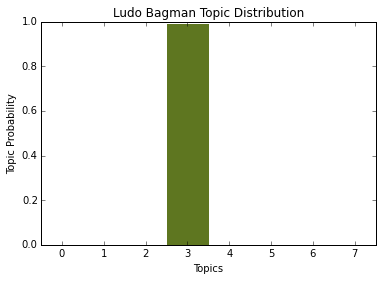

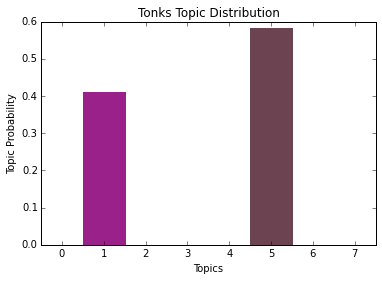

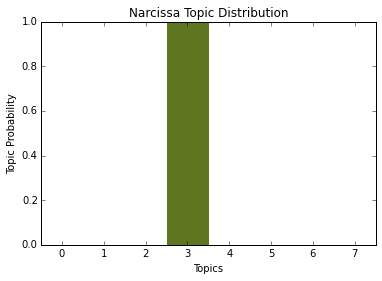

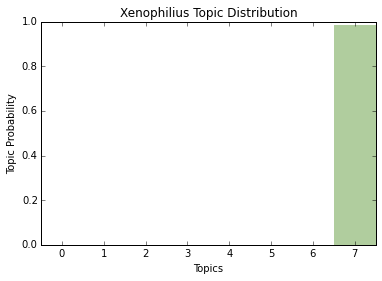

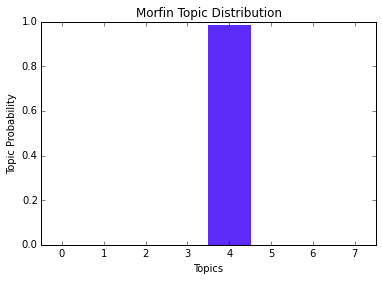

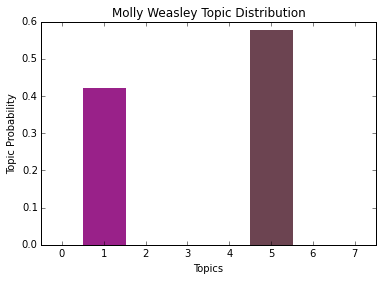

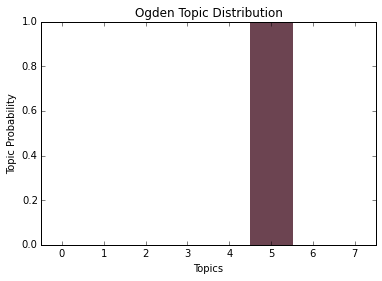

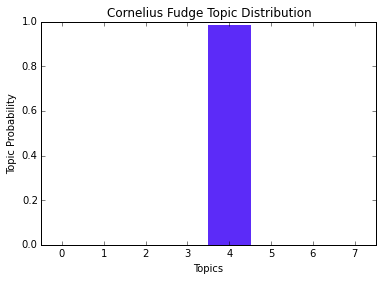

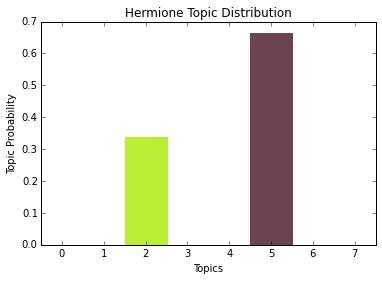

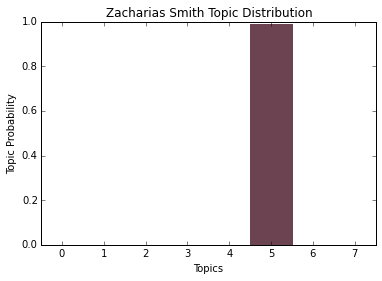

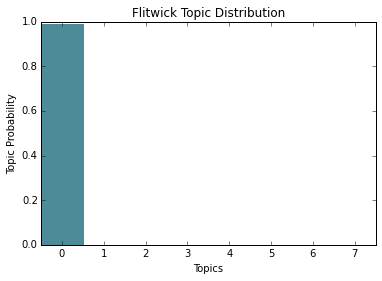

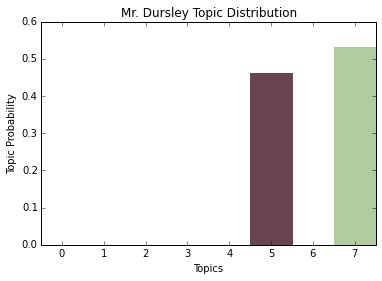

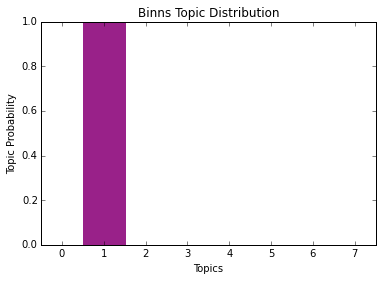

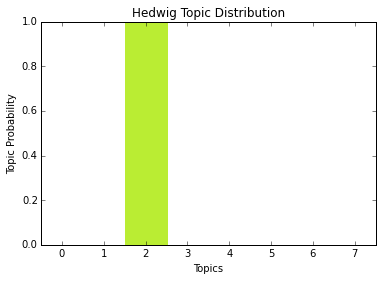

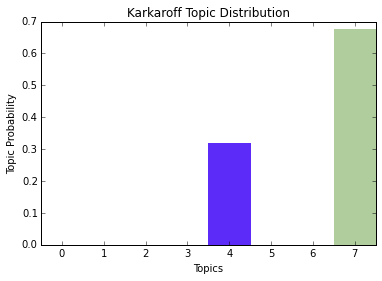

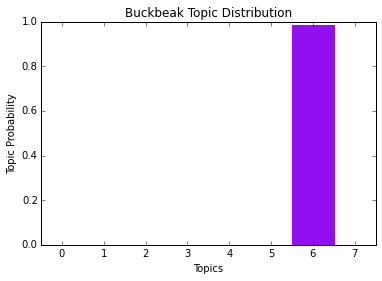

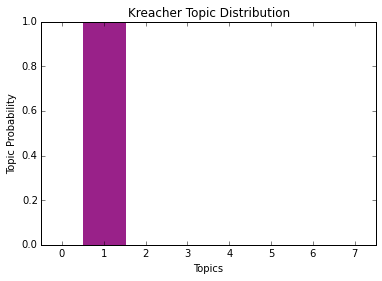

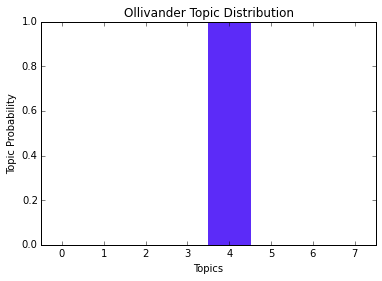

In [210]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

#### Use KMeans (is this the best choice?) and print out the clusters list

In [211]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 0, 3, 3, 3, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 3, 2, 2, 0, 2, 3, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 1, 0, 1, 0, 2, 1, 2, 3, 3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 3, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0]
silhouette score: 0.463662511132
inertia: 45.1460970329


#### Print out characters and cluster assignments (in order)

In [212]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Dudley', 0)
('Cho', 0)
('Madam Hooch', 0)
('Bertha Jorkins', 0)
('Karkaroff', 0)
('Fred', 0)
('Marietta', 0)
('Rufus Scrimgeour', 0)
('Kingsley', 0)
('Moody', 0)
('James', 0)
('Voldemort', 0)
('Albus Dumbledore', 0)
('Maxime', 0)
('Pettigrew', 0)
('Ministry of Magic', 0)
('Hogwarts Express', 0)
('Aberforth', 0)
('Bathilda', 0)
('Colin', 0)
('Neville', 0)
('Norbert', 0)
('Charlie', 0)
('Malfoy', 0)
('Lucius', 0)
('Arthur', 0)
('Mr. Crouch', 0)
('Slytherin', 0)
('Borgin', 0)
('Parvati', 0)
('Krum', 0)
('Nick', 0)
('Hogwarts', 0)
('Marge', 0)
('Lee Jordan', 0)
('Stan', 0)
('Gregorovitch', 0)
('Justin', 0)
('Dumbledore', 0)
('Barty Crouch', 0)
('Cedric', 0)
('Grawp', 0)
('Harry', 0)
('Pigwidgeon', 0)
('Trelawney', 0)
('Petunia Dursley', 0)
('Luna', 0)
('Muriel', 0)
('Quirrell', 0)
('Mr. Weasley', 0)
('Zabini', 0)
('Mundungus', 0)
('Xenophilius', 0)
('Morfin', 0)
('Cornelius Fudge', 0)
('Mr. Dursley', 0)
('Binns', 0)
('Hedwig', 0)
('Buckbeak', 0)
('Kreacher', 0)
('Ollivander', 0)
('Madam 

#### Create data frame for clusters and characters

In [213]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [214]:
frame['clusters'].value_counts() 

0    61
2    29
1    17
3    14
Name: clusters, dtype: int64

#### Show visual cluster plot (all this code is heavily derivative of that guy's tutorial)

In [215]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [216]:
# TODO: change so that this automatically works with any of number clusters
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

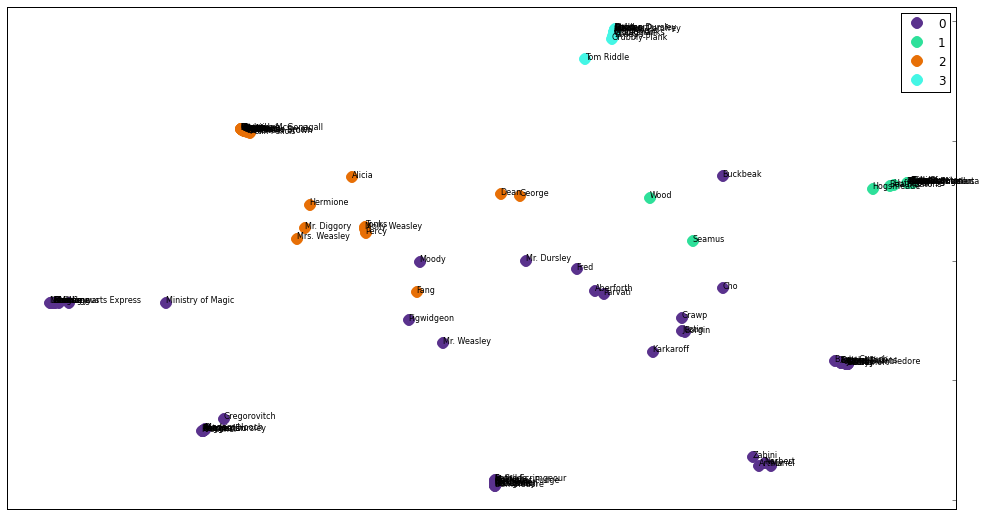

In [217]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [218]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters (again taken from the dude's tutorial)

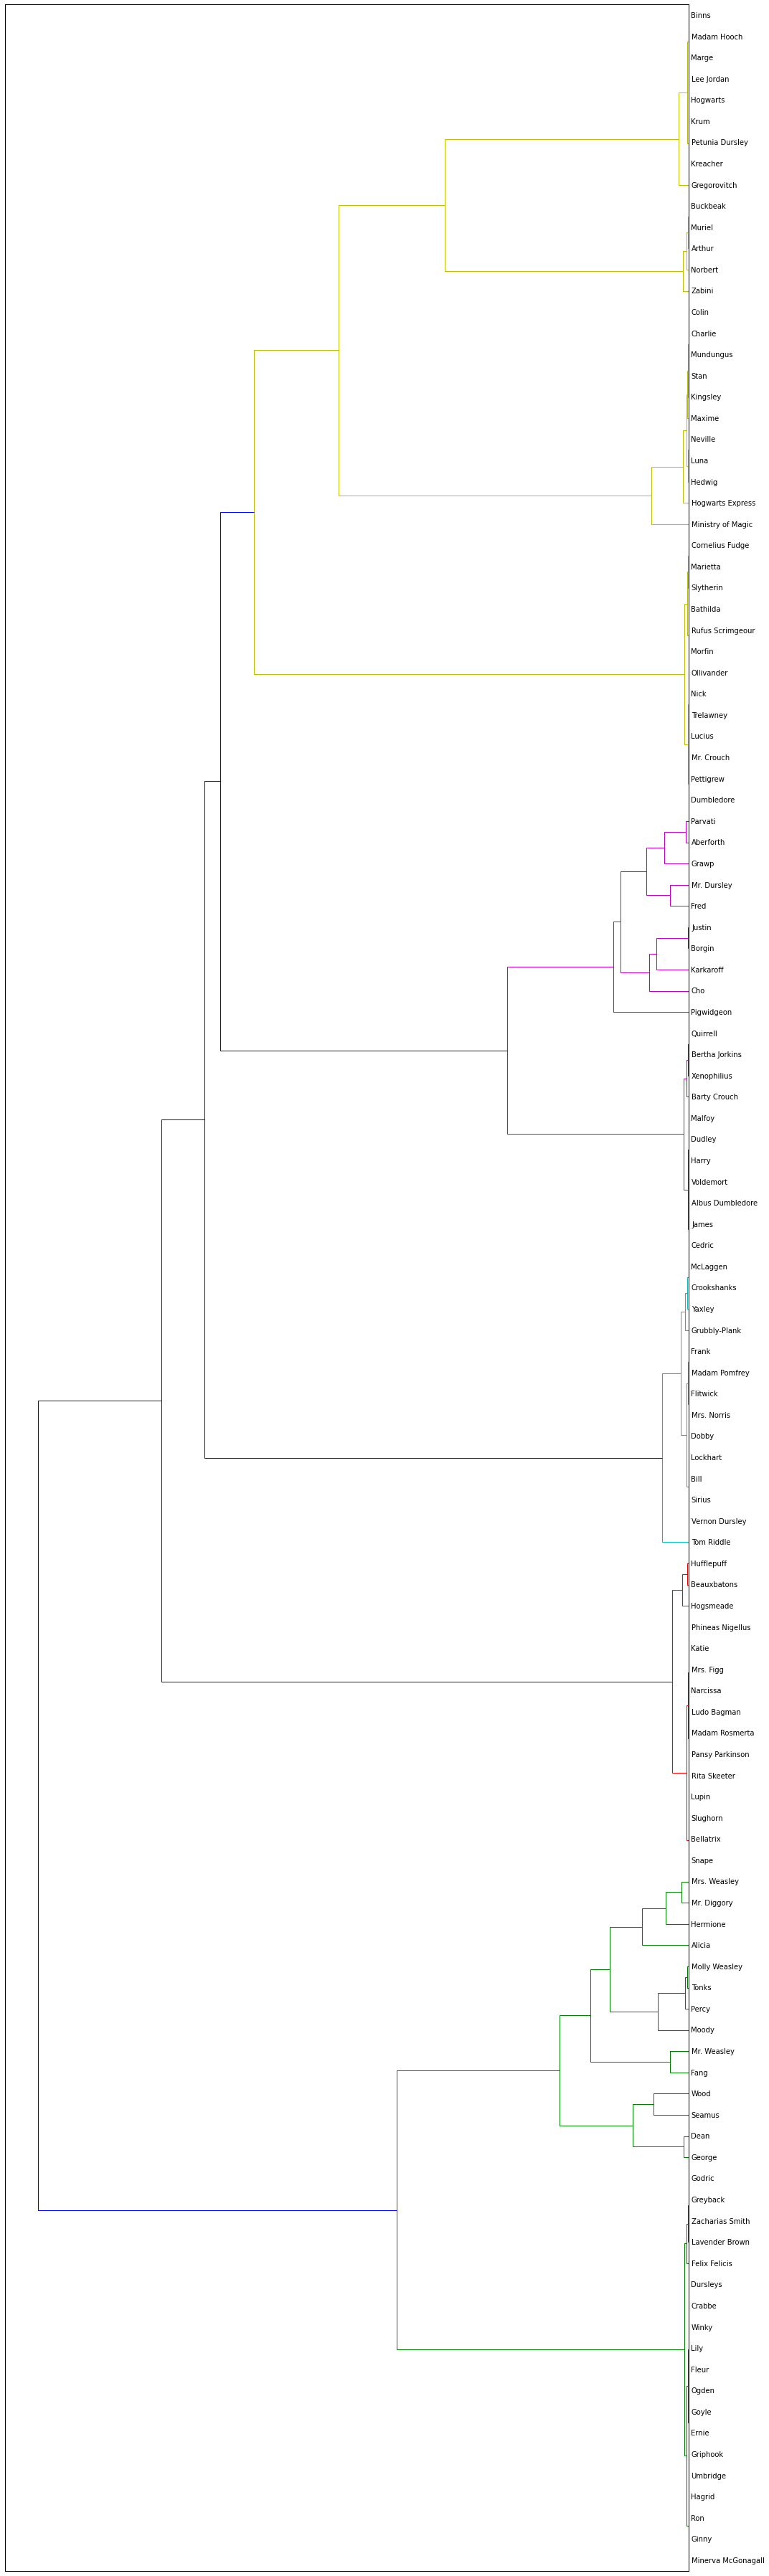

In [219]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [220]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [221]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [222]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

103


In [223]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

122 0
Madam Rosmerta
[0, 0, 1, 0]
[0, 0, 0, 0.989049727415515, 0, 0, 0, 0]

11 98
Ginny Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.99915466327080582, 0, 0]

116 74
Stan Shunpike
[0, 0, 1, 0]
[0, 0, 0.99157774045104319, 0, 0, 0, 0, 0]

0 3
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0.99786326345991927, 0, 0, 0, 0]

31 4
Dudley
[0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.99838415115094725]

1 5
Cho
[1, 0, 0, 0]
[0, 0, 0, 0.37701959919788619, 0, 0, 0, 0.61918888072536626]

18 49
Arthur Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0.98932113527156018, 0]

84 88
Colin Creevey
[0, 0, 1, 0]
[0, 0, 0.9926388613093432, 0, 0, 0, 0, 0]

65 6
Madam Hooch
[0, 0, 1, 0]
[0, 0.99047773068088985, 0, 0, 0, 0, 0, 0]

88 7
Lavender Brown
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0.98248528840824878, 0, 0]

135 1
Fang
[0, 0, 0, 1]
[0, 0, 0, 0, 0.5258135182370588, 0.46827599623663313, 0, 0]

66 8
Bertha Jorkins
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0.98692621774419009]

79 84
Seamus Finnigan
[0, 0, 1, 0]
[0, 0, 0, 0.55752243666377976, 0, 0.098122216875

In [224]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.67307692  0.70588235]
Precision:
[ 0.42857143  0.5       ]
Recall:
[ 0.4         0.26666667]

Antagonists
Accuracy:
[ 0.75        0.74509804]
Precision:
[ 0.  0.]
Recall:
[ 0.  0.]

Neutral
Accuracy:
[ 0.51923077  0.64705882]
Precision:
[ 0.33333333  0.53333333]
Recall:
[ 0.25        0.42105263]

Animals
Accuracy:
[ 0.92307692  0.90196078]
Precision:
[ 0.  0.]
Recall:
[ 0.  0.]

